In [1]:
pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to c:\users\user\appdata\local\temp\pip-req-build-zefo3dsg
  Resolved https://github.com/keras-team/keras-preprocessing.git to commit 3e380065d4afc7347aaee8d89325a16b22158438
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-preprocessing.git 'C:\Users\user\AppData\Local\Temp\pip-req-build-zefo3dsg'


In [2]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

In [3]:
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers

In [4]:
from tqdm import tqdm
from time import perf_counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

## 데이터 전처리

In [5]:
df = pd.read_csv("./data/FamilyData/Val/FamilyData_Val_DF.csv",index_col=0)

In [6]:
df.head()

,img_path,M,F,0's,10's,20's,30's,40's,50's,60+
0,F0801_IND_F_48_-45_01.JPG,1,0,0,0,0,0,1,0,0
1,F0801_IND_F_48_-45_02.JPG,1,0,0,0,0,0,1,0,0
2,F0801_IND_F_48_-90_01.JPG,1,0,0,0,0,0,1,0,0
3,F0801_IND_F_48_-90_02.JPG,1,0,0,0,0,0,1,0,0
4,F0801_IND_F_48_0_01.JPG,1,0,0,0,0,0,1,0,0


In [7]:
columns=["M","F","0's","10's","20's","30's","40's","50's","60+"]

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, random_state=777, test_size=0.2) 
train_df, val_df = train_test_split(train_df, random_state=777, test_size=0.2) 

len(train_df) , len(val_df), len(test_df)

(2048, 512, 640)

In [9]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [10]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="C:/Users/user/Desktop/Preprocessed_Datasets(FamilyData_Val)",
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(224,224))

Found 2048 validated image filenames.


In [11]:
valid_generator=test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="C:/Users/user/Desktop/Preprocessed_Datasets(FamilyData_Val)",
    x_col="img_path",
    y_col=columns,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="other",
    target_size=(224,224))

Found 512 validated image filenames.


In [12]:
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="C:/Users/user/Desktop/Preprocessed_Datasets(FamilyData_Val)",
    x_col="img_path",
    y_col=columns,
    batch_size=1,
    seed=42,
    shuffle=False,
    class_mode= "other", #None
    target_size=(224,224))

Found 640 validated image filenames.


## 모델 전이학습

### 1) Import VGG16

In [13]:
#model
from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet',
              include_top=False, 
              input_shape = (224,224,3))


In [14]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 2) Model Define

In [15]:
model = models.Sequential()
model.add(vgg16)

model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(9,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                                 
Total params: 21154505 (80.70 MB)
Trainable params: 21154505 (80.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3) Model Compile

In [16]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.00005),
              metrics = ['accuracy'])

### 4) Model Fit

In [17]:
%%time

Hist_dandc = model.fit(train_generator,
                        # steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator,
                        # validation_steps=STEP_SIZE_VALID,
                        epochs=30)

Epoch 1/30
64/64 [==============================] - 1001s 16s/step - loss: 0.4547 - accuracy: 0.6631 - val_loss: 0.3621 - val_accuracy: 0.8750
Epoch 2/30
64/64 [==============================] - 835s 13s/step - loss: 0.3072 - accuracy: 0.9194 - val_loss: 0.2892 - val_accuracy: 0.9609
Epoch 3/30
64/64 [==============================] - 527s 8s/step - loss: 0.2031 - accuracy: 0.9512 - val_loss: 0.2483 - val_accuracy: 0.9160
Epoch 4/30
64/64 [==============================] - 526s 8s/step - loss: 0.1327 - accuracy: 0.9399 - val_loss: 0.2078 - val_accuracy: 0.9316
Epoch 5/30
64/64 [==============================] - 530s 8s/step - loss: 0.0748 - accuracy: 0.9404 - val_loss: 0.1844 - val_accuracy: 0.9414
Epoch 6/30
64/64 [==============================] - 530s 8s/step - loss: 0.0444 - accuracy: 0.9482 - val_loss: 0.1792 - val_accuracy: 0.9590
Epoch 7/30
64/64 [==============================] - 530s 8s/step - loss: 0.0254 - accuracy: 0.9160 - val_loss: 0.2098 - val_accuracy: 0.8828
Epoch 8/30

In [18]:
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

640/640 [==============================] - 62s 97ms/step - loss: 0.2939 - accuracy: 0.9297
Loss = 0.29390
Accuracy = 0.92969


* Model Save

In [19]:
model.save('C:/Users/user/Desktop/mtvs/project4/vgg16.h5')

c:\Users\user\.conda\envs\project4\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
print(Hist_dandc.history['val_loss'])
print(Hist_dandc.history['loss'])

[0.3621269762516022, 0.28916221857070923, 0.24826142191886902, 0.20778191089630127, 0.18439726531505585, 0.17919059097766876, 0.20978373289108276, 0.23093679547309875, 0.2248767912387848, 0.21120429039001465, 0.2579309642314911, 0.24978554248809814, 0.25689372420310974, 0.2401478886604309, 0.22874216735363007, 0.22113800048828125, 0.2157479077577591, 0.2657585144042969, 0.26193687319755554, 0.2558957040309906, 0.20189574360847473, 0.2375272959470749, 0.2735300660133362, 0.2584531903266907, 0.24874740839004517, 0.27210524678230286, 0.28371959924697876, 0.2924323081970215, 0.30005669593811035, 0.30625563859939575]
[0.454719215631485, 0.30716070532798767, 0.20313262939453125, 0.1326707899570465, 0.0748482495546341, 0.04438314959406853, 0.02535044401884079, 0.028049979358911514, 0.02195018157362938, 0.012648539617657661, 0.006242820993065834, 0.013537390157580376, 0.005782439839094877, 0.006021670065820217, 0.008418641053140163, 0.008289778605103493, 0.004660715814679861, 0.002715033944696

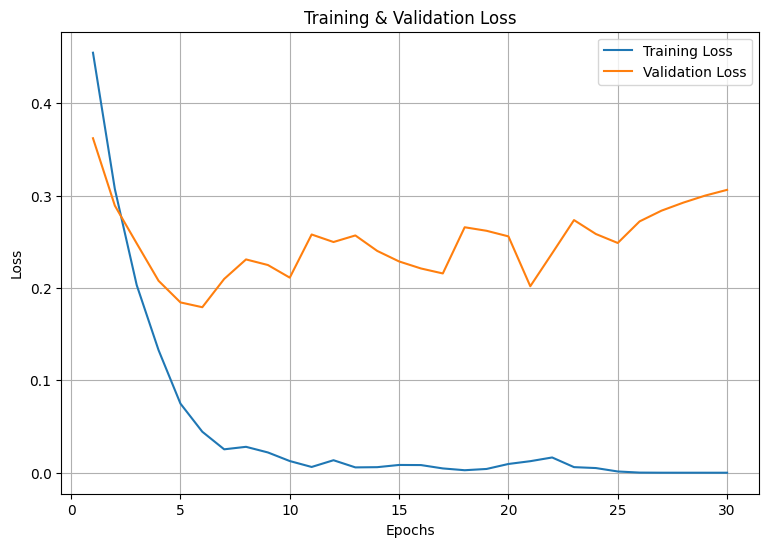

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

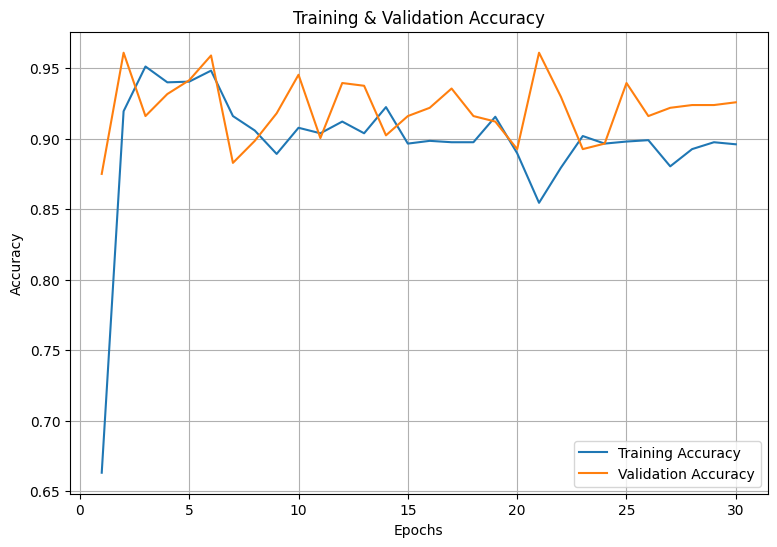

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()